In [1]:
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

import random

random.seed(3)

In [2]:
fiberseq_path = "test_fiberseq.bam"

In [3]:
def sample_reads(bam_file, num_reads=10000):
    # Open the input BAM file
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        # Get the total number of reads
        total_reads = bam.mapped + bam.unmapped

        # Ensure num_reads is not greater than total reads
        if num_reads > total_reads:
            num_reads = total_reads
            #raise ValueError("num_reads cannot be greater than the total number of reads in the BAM file")

        # Generate random indices for sampling
        sampled_indices = set(random.sample(range(total_reads), num_reads))

        sampled_reads = []
        current_index = 0

        # Iterate over all reads and select the sampled ones
        for read in bam.fetch(until_eof=True):
            if current_index in sampled_indices:
                sampled_reads.append(read)
                sampled_indices.remove(current_index)
                if not sampled_indices:
                    break
            current_index += 1

    return sampled_reads

In [4]:
def create_dataframes(reads):
    # dict to hold modification type (ex m/a)
    mod_dict = defaultdict(lambda: defaultdict(int))

    # Iterate over alignments
    for read in reads:
        if read.modified_bases_forward:
            for mod in read.modified_bases_forward.keys():
                mod_type = mod[2]
                for mod_site in read.modified_bases_forward[mod]:
                    MLscore = mod_site[1]
                    mod_dict[mod_type][MLscore] += 1

    for mod in mod_dict:
        # create dataframe for a given modification
        index = list(mod_dict[mod].keys())
        df = pd.DataFrame.from_dict(mod_dict[mod], orient='index', columns=['count']).sort_index()
        yield df, mod

In [25]:
def plot_histogram(dataframe, mod):
    
    plt.figure(figsize=(8, 6))
    plt.hist(dataframe.index, 
             weights=dataframe['count'], 
             bins=128, 
             color='skyblue', 
             range=(0,256),
             edgecolor='black')
    plt.xlabel('ML score')
    plt.ylabel('Count')
    plt.title(f'\'{mod}\' Modification Count by ML score')

    # add vertical line at 0.8 (~204)
    plt.axvline(x=204, color='red', linestyle='--', linewidth=1)
    # add vertical line and text at the 66th percentile
    dataframe['cum_sum'] = dataframe['count'].cumsum()
    twothird = dataframe.loc[dataframe['cum_sum'] >= (max(dataframe['cum_sum'])*2/3)].iloc[0]
    print( twothird.name )
    plt.axvline(x = twothird.name, 
                color = 'red', ls='-') # 0.5 ML threshold
    plt.text(x= twothird.name, 
             y= max(dataframe['count'])/1.2, 
             s=f'(66th percentile ML: {twothird.name})', 
             rotation=90, va='center', ha='right', color='red',fontsize=5)
    # Set x-axis ticks and labels in multiples of 32
    ticks = np.arange(0, 257, 32)  # Create an array from 0 to 256 with step 32
    plt.xticks(ticks)

    plt.xlim(0,256)
    '''output_name = f'{prefix}_ML-{mod}.png'
    plt.savefig(output_name, 
                dpi=1200)'''
    plt.show()
    plt.clf()

In [14]:
create_dataframes( sample_reads( fiberseq_path ) )

<generator object create_dataframes at 0x7f5bfdfbef10>

In [7]:
#prob_df['cum_sum'] = prob_df['count'].cumsum()
#twothird = prob_df.loc[prob_df['cum_sum'] >= (max(prob_df['cum_sum'])*2/3), 'range_end'].iloc[0]

a 
      count
244    581
245    639
246    628
247    693
248    836
249    880
250   1013
251   1158
252   1383
253   1625
254   1328
255    149
252


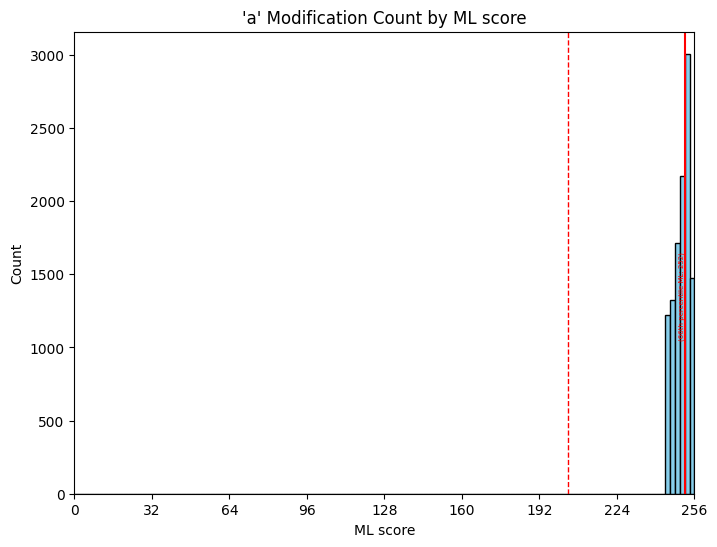

m 
      count
0      114
1       91
2       83
3       65
4       58
..     ...
251    290
252    325
253    434
254    684
255   1725

[256 rows x 1 columns]
248


<Figure size 640x480 with 0 Axes>

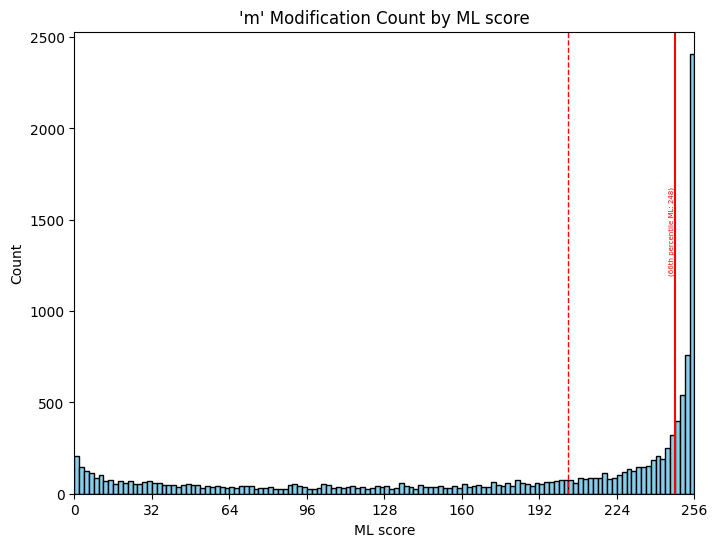

<Figure size 640x480 with 0 Axes>

In [26]:
for df, mod in create_dataframes( sample_reads( fiberseq_path ) ):
    print(mod, '\n', df)
    plot_histogram( df, mod )
    